In [63]:
import os
import h5py
import cv2 # pip install opencv-python

import scipy.ndimage as sp
import pandas as pd
import seaborn as sns
import numpy as np
import tensorflow as tf
import random

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.cm as cm

from PIL import Image
from scipy.ndimage.filters import gaussian_filter

%matplotlib inline

In [3]:
os.chdir('/Users/hyunwoogu/Dropbox/2019/2019Autumn/Graduation/ResearchGrant/experiment/stimuli')

## Task structure

+ 


## Subroutines

+ Given Coord. of Center Point -> Matrix of the image part
+ 

In [805]:
def getAttention(center, img=img, w=480, h=480):
    halfw = int(w/2)
    halfh = int(h/2)
    
    return img[(center[0]-halfw):(center[0]+halfw),(center[1]-halfh):(center[1]+halfh),:]

In [806]:
# return normalized output
def getAttention2(center, img=img, w=480, h=480, reduce_factor=12):
    halfw = int(w/2)
    halfh = int(h/2)
    
    res   = img[(center[0]-halfw):(center[0]+halfw),(center[1]-halfh):(center[1]+halfh),:]
    res   = np.array(Image.fromarray(res).resize((int(w/reduce_factor),int(h/reduce_factor))))
    res   = np.mean(res, axis=2)[..., np.newaxis]    
    res   = res.astype(np.float32)
    res   = (res - np.mean(res))/np.std(res)

    return res

## Generate Stimuli

In [6]:
FileNames = os.listdir()

w,h=Image.open(FileNames[0]).size
N=len(FileNames)

arr=np.zeros((h,w,3),np.float)

for im in FileNames:
    imarr= np.array(Image.open(im),dtype=np.float)
    arr=arr+imarr/N

arr=np.array(np.round(arr),dtype=np.uint8)
out=Image.fromarray(arr,mode="RGB")
out.save("Average.png")
# out.show()

img = cv2.imread("Average.png", 1)
img = cv2.resize(img, (1600, 1200), interpolation=cv2.INTER_CUBIC)

In [185]:
for i in range(32):
    if i == 0:
        img_list = cv2.imread(str(i+1) + ".png", 1)
        img_list = cv2.resize(img_list, (1600, 1200), interpolation=cv2.INTER_CUBIC)
        img_list = img_list[np.newaxis,:,:,:]
    else:
        im = cv2.imread(str(i+1) + ".png", 1)
        im = cv2.resize(im, (1600, 1200), interpolation=cv2.INTER_CUBIC)
        im = im[np.newaxis,:,:,:]
        img_list = np.concatenate((img_list,im),axis=0)

## Points of Fixation

+ Central
+ Peripheral

In [1130]:
# note that (xcoord, ycorrd)
centL = [600, 450]
centR = [1000, 450]

periL = [600, 750]
periR = [1000, 750]

In [579]:
fix_list = [centL, centR, periL, periR]

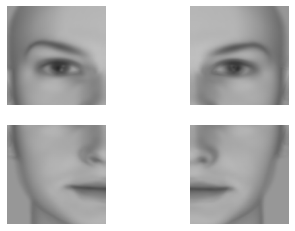

In [9]:
plt.subplot(221)
plt.imshow(getAttention(np.flip(centL)))
plt.axis('off')
plt.subplot(222)
plt.imshow(getAttention(np.flip(centR)))
plt.axis('off')
plt.subplot(223)
plt.imshow(getAttention(np.flip(periL)))
plt.axis('off')
plt.subplot(224)
plt.imshow(getAttention(np.flip(periR)))
plt.axis('off')
plt.show()

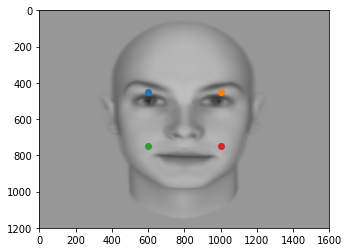

In [432]:
plt.imshow(img)
plt.xlim(0, 1600)
plt.ylim(1200, 0)
plt.scatter(centL[0],centL[1])
plt.scatter(centR[0],centR[1])
plt.scatter(periL[0],periL[1])
plt.scatter(periR[0],periR[1])


plt.show()

### Convolution Neural Network

+ Representational similarity betweeen identical faces

+ input normalization is needed!
+ attentional centers should be on the centeral (square)

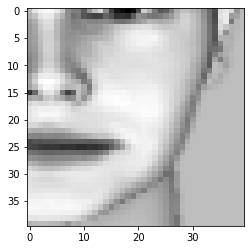

In [1165]:
plt.imshow(getAttention2(np.flip(periR),img=img_list[24])[:,:,0], cmap="gray")
plt.show()

In [ ]:
np.flip(fix)

In [ ]:
ground_truth = np.zeros(bs,dtype=np.float32)

In [742]:
n_class = 8

In [790]:
def genPrepTrials():
    ran_x = np.random.uniform(low=600, high=1000, size=bs)
    ran_y = np.random.uniform(low=450, high=750, size=bs)

    stim_x = np.random.normal(scale=0.02, size=(bs,span,span,1)) # measurement noise
    ground_truth = np.zeros(bs,dtype=np.float32)

    for i in range(bs):
        ground_truth[i] = np.random.choice(n_class,1).astype(np.float32)*(32./n_class)
        stim_x[i,:,:,:] += getAttention2([int(ran_y[i]),int(ran_x[i])],img=img_list[int(ground_truth[i])])
    return({'stim_x':stim_x, 'ground_truth':ground_truth})

In [744]:
testest = genPrepTrials()

0.0


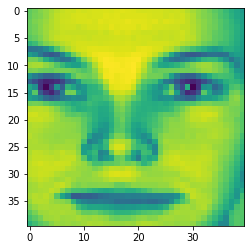

In [778]:
# testest = genPrepTrials()
t = np.random.randint(bs)

print(testest['ground_truth'][t])
plt.imshow(testest['stim_x'][t,:,:,0])
plt.show()

In [578]:
def genPrepTrials(fix):
#     ran_x = np.random.uniform(low=600, high=1000, size=(bs,2))
#     ran_y = np.random.uniform(low=450, high=750, size=(bs,2))

    stim_x1 = np.random.normal(scale=0.02, size=(bs,span,span,1)) # measurement noise
    stim_x2 = np.random.normal(scale=0.02, size=(bs,span,span,1)) # measurement noise

    ground_truth   = np.zeros((bs,2),dtype=np.int64)
    desired_output = np.random.choice(2, bs, replace=True)

    for i in range(bs):
        # "identical" trials
        if desired_output[i]:
            ground_truth[i,:] = np.random.choice(range(32),1)
            stim_x1[i,:,:,:] += getAttention2(np.flip(fix),img=img_list[ground_truth[i,0]])
            stim_x2[i,:,:,:] += getAttention2(np.flip(fix),img=img_list[ground_truth[i,1]])
#             stim_x1[i,:,:,:] += getAttention2([int(ran_y[i,0]),int(ran_x[i,0])],img=img_list[ground_truth[i,0]])
#             stim_x2[i,:,:,:] += getAttention2([int(ran_y[i,1]),int(ran_x[i,1])],img=img_list[ground_truth[i,1]])
        # "different" trials
        else:
            ground_truth[i,0] = np.random.choice(range(32),1)
            ground_truth[i,1] = (ground_truth[i,0]+np.random.choice((-1.,1.),1)*diff_level)%32
            stim_x1[i,:,:,:] += getAttention2(np.flip(fix),img=img_list[ground_truth[i,0]])
            stim_x2[i,:,:,:] += getAttention2(np.flip(fix),img=img_list[ground_truth[i,1]])

#             stim_x1[i,:,:,:] += getAttention2([int(ran_y[i,0]),int(ran_x[i,0])],img=img_list[ground_truth[i,0]])
#             stim_x2[i,:,:,:] += getAttention2([int(ran_y[i,1]),int(ran_x[i,1])],img=img_list[ground_truth[i,1]])

#     return({'x':ran_x, 'y':ran_y, 'stim_x1':stim_x1, 'stim_x2':stim_x2, 'ground_truth':ground_truth, 'desired_output':desired_output})
    return({'fix': fix, 'stim_x1':stim_x1, 'stim_x2':stim_x2, 'ground_truth':ground_truth, 'desired_output':desired_output})

In [877]:
model.layers[5].output

<tf.Tensor 'Dfc/Tanh:0' shape=(?, 128) dtype=float32>

In [ ]:
getAttention2(np.flip(fix),img=img_list[ground_truth[i,0]])

In [992]:
testTrials['stim_x'].shape

(512, 40, 40, 1)

In [1078]:
np.random.normal(loc=0,scale=0.02,size=32)

array([ 0.01435858, -0.02132403, -0.01324142, -0.00873027, -0.00339212,
       -0.0182627 ,  0.00475877, -0.0118902 ,  0.00890087,  0.03436708,
       -0.00274589, -0.03259189,  0.01791288,  0.01651237, -0.03038985,
        0.0233799 ,  0.02142381, -0.03374396, -0.02472029, -0.01223158,
        0.00957724,  0.02464386,  0.00996019,  0.01882903,  0.01164579,
       -0.03089978, -0.01444742,  0.00335788,  0.00419025,  0.0125654 ,
       -0.01062012, -0.01660593])

In [1081]:
predict_res.shape

(1, 32)

In [1139]:
example_faces = np.array([0,4,8,12,16,20,24,28], dtype=np.int32)

In [1146]:
cnn_summ = np.zeros((8,100,))

array([4, 0])

In [1148]:
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
from sklearn.svm import SVR
from mpl_toolkits.mplot3d import Axes3D

pca3 = PCA(n_components=3)
svm_classifier = SVC(gamma='auto')
svr_predictor  = SVR(gamma='scale', C=1.0, epsilon=0.2)
n_cv = 32

In [1158]:
np.arange(32)/32*360

array([  0.  ,  11.25,  22.5 ,  33.75,  45.  ,  56.25,  67.5 ,  78.75,
        90.  , 101.25, 112.5 , 123.75, 135.  , 146.25, 157.5 , 168.75,
       180.  , 191.25, 202.5 , 213.75, 225.  , 236.25, 247.5 , 258.75,
       270.  , 281.25, 292.5 , 303.75, 315.  , 326.25, 337.5 , 348.75])

In [1160]:
for f in example_faces:
    for iterr in range(100):
        curr_fix = centL + np.random.choice(range(100),size=(2),replace=True)
        predict_res  = model.predict(getAttention2(np.flip(curr_fix),img=img_list[f]).reshape((1,40,40,1))).reshape((32,))
        predict_res /= np.linalg.norm(predict_res)
        if (f==0 & iterr==0):
            cnn_summ = pd.DataFrame({"Face Degree":np.arange(32)/32*360, "Face":f/32*360, "Probability(normalized)":predict_res})
        else:
            cnn_summ = cnn_summ.append(pd.DataFrame({"Face Degree":np.arange(32)/32*360, "Face":f/32*360, "Probability(normalized)":predict_res}))

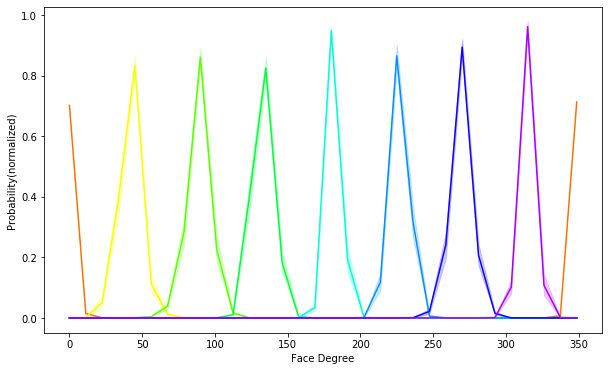

In [1162]:
plt.figure(figsize = (10,6))
sns.lineplot(x="Face Degree", y="Probability(normalized)", hue="Face", data=cnn_summ, palette=sns.color_palette('gist_rainbow', n_colors=8), legend=False)
plt.show()

In [ ]:
n_cv = 32
for t in range(eyeTrial.numSteps):
    CV_pos  = cross_val_score(svm_classifier, res_h_pos[t,:,:], DM_groundtruth_pos[:,:][t,:], cv=32)
    CV_path = cross_val_score(svm_classifier, res_h_path[t,:,:], DM_groundtruth_path[:,:][t,:], cv=32)
    CV_res = np.concatenate((CV_pos,CV_path))
    time_ind = np.repeat(list(range(eyeTrial.numSteps))[t],n_cv*2)
    hypo_ind = np.repeat(["Position","Path"],[n_cv,n_cv])
    if (t==0):
        CV = pd.DataFrame({"Time":time_ind, "Hypothesis":hypo_ind, "CV":CV_res})
    else:
        CV = CV.append(pd.DataFrame({"Time":time_ind, "Hypothesis":hypo_ind, "CV":CV_res}))
        
sns.lineplot(x="Time", y="CV", hue="Hypothesis", data=CV)
plt.show()

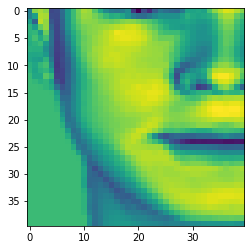

In [1135]:
plt.imshow(getAttention2(np.flip(periL),img=img_list[t]).reshape((40,40)))
plt.show()

In [ ]:
predict_res = model.predict(getAttention2(np.flip(centL),img=img_list[t]).reshape((1,40,40,1)))

In [1147]:
predict_res.shape

(1, 32)

11


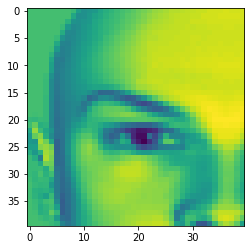

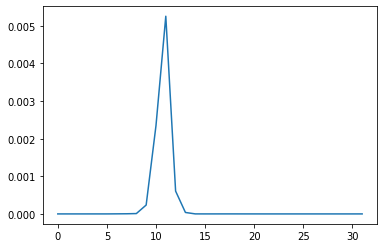

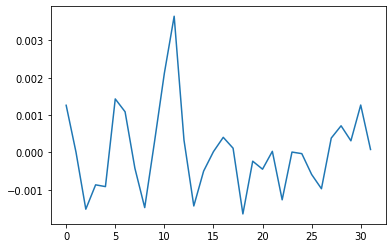

In [1137]:
# testTrials = genPrepTrials()
t = np.random.randint(32)
# t = 12

# fix = [600,603]

# add_noise = np.random.normal(scale=0.02,size=(1,40,40,1))
predict_res = model.predict(getAttention2(np.flip(centL),img=img_list[t]).reshape((1,40,40,1)))

# print(testTrials['ground_truth'][t])
# plt.imshow(testTrials['stim_x'][t,:,:,0])
print(t)
plt.imshow(getAttention2(np.flip(centL),img=img_list[t]).reshape((40,40)))
plt.show()

plt.plot(predict_res.T)
plt.show()

plt.plot(predict_res.T + np.random.normal(loc=0,scale=0.001,size=(32,1)))
plt.show()

In [1055]:
fcLayerModel = Model(inputs =model.input,
                     outputs=model.get_layer(model.layers[5].name).output)

#### Train!

In [678]:
span = 40 # attentional span size
ks = 10 # kernel size
bs = 512 # batch size
num_iter = 2000
diff_level = 8

In [679]:
tf.reset_default_graph()  # reset graphs in background

In [680]:
X = tf.placeholder(tf.float32, [None, span, span, 1])
Y = tf.placeholder(tf.float32, [None])

In [681]:
W = tf.Variable(tf.random_normal([ks, ks, 1, 32], stddev=0.01))

L = tf.nn.conv2d(X, W, strides=[1, 3, 3, 1], padding='SAME')
L = tf.nn.relu(L)

fc_dim = L.shape[1].value * L.shape[2].value * L.shape[3].value

In [682]:
W_fc = tf.Variable(tf.random_normal([fc_dim, 512], stddev=0.01))
W_output = tf.Variable(tf.random_normal([512, 1], stddev=0.01))

L_fc = tf.matmul(tf.reshape(L, [-1, fc_dim]), W_fc)
L_fc = tf.nn.relu(L_fc) # representation of pic 2

L_output = tf.matmul(L_fc, W_output)

In [683]:
cost = tf.reduce_mean(tf.abs(tf.math.tan((L_output-Y)/np.pi/64.)))
optimizer = tf.train.AdamOptimizer(0.001).minimize(cost)

In [684]:
cost_hist = np.zeros(num_iter)

In [685]:
with tf.Session(graph=tf.get_default_graph()) as sess:
    sess.run(tf.global_variables_initializer())    
    for i in range(num_iter):
        trial_info = genPrepTrials()
        _, cost_val = sess.run([optimizer, cost],
                 feed_dict = {X: trial_info['stim_x'], 
                              Y:  trial_info['ground_truth']})
        cost_hist[i] = cost_val
        print("iter:",i,", cost:",cost_val)
        weights = sess.run({'W':W, 'W_fc':W_fc, 'L_output': L_output}, 
                           feed_dict = {X: trial_info['stim_x'], 
                                        Y:  trial_info['ground_truth']})

iter: 0 , cost: 0.075391725
iter: 1 , cost: 0.074310735
iter: 2 , cost: 0.07475655
iter: 3 , cost: 0.068828456
iter: 4 , cost: 0.062260855
iter: 5 , cost: 0.05071756
iter: 6 , cost: 0.04314928
iter: 7 , cost: 0.040743552
iter: 8 , cost: 0.043517403
iter: 9 , cost: 0.050530322
iter: 10 , cost: 0.047092587
iter: 11 , cost: 0.042432662
iter: 12 , cost: 0.039482415
iter: 13 , cost: 0.039350256
iter: 14 , cost: 0.04108801
iter: 15 , cost: 0.041793313
iter: 16 , cost: 0.041489266
iter: 17 , cost: 0.04068256
iter: 18 , cost: 0.0428143
iter: 19 , cost: 0.04068344
iter: 20 , cost: 0.041685022
iter: 21 , cost: 0.038387135
iter: 22 , cost: 0.03957229
iter: 23 , cost: 0.03979738
iter: 24 , cost: 0.042426772
iter: 25 , cost: 0.04069021
iter: 26 , cost: 0.041475035
iter: 27 , cost: 0.041952074
iter: 28 , cost: 0.038901556
iter: 29 , cost: 0.040470928
iter: 30 , cost: 0.03967701
iter: 31 , cost: 0.040373534
iter: 32 , cost: 0.04004337
iter: 33 , cost: 0.03988345
iter: 34 , cost: 0.039476994
iter: 35 

In [690]:
y_onehot = np.eye(32)[trial_info['ground_truth'].astype(np.int64)].astype(np.int64)

In [865]:
from keras.models import Sequential, Model
from keras.layers import Subtract, Input
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv1D, MaxPooling1D, Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils import np_utils
import keras.backend as K 
K.clear_session()

In [866]:
n_class = 32
ks = 3

In [867]:
model = Sequential()
model.add(Conv2D(256, kernel_size=ks, padding='same', activation='relu',
                    input_shape=(span, span, 1),name='Dconv1'))
model.add(MaxPooling2D(pool_size=2, name='Dmaxpool1'))
model.add(Conv2D(128, kernel_size=ks, padding='same', name='Dconv2', activation='relu'))
model.add(MaxPooling2D(pool_size=2, name='Dmaxpool2'))

model.add(Flatten())
model.add(Dense(128, name='Dfc', activation='tanh'))
model.add(Dense(n_class, name='Doutput', activation='sigmoid'))

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Dconv1 (Conv2D)              (None, 40, 40, 256)       2560      
_________________________________________________________________
Dmaxpool1 (MaxPooling2D)     (None, 20, 20, 256)       0         
_________________________________________________________________
Dconv2 (Conv2D)              (None, 20, 20, 128)       295040    
_________________________________________________________________
Dmaxpool2 (MaxPooling2D)     (None, 10, 10, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 12800)             0         
_________________________________________________________________
Dfc (Dense)                  (None, 128)               1638528   
_________________________________________________________________
Doutput (Dense)              (None, 32)               

In [868]:
OPTIM = Adam()
model.compile(loss='categorical_crossentropy', optimizer=OPTIM, metrics=['accuracy'])
History = {}

In [869]:
for i in range(1000):
    trial_info = genPrepTrials()
    y_onehot = np.eye(n_class)[(trial_info['ground_truth']/(32/n_class)).astype(np.int64)].astype(np.int64)
    print("Iter:", str(i))
    History[i]  = model.fit(trial_info['stim_x'], y_onehot, batch_size = 128, epochs=1, verbose=1)

Iter: 0
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 3.5109 - accuracy: 0.0273
Iter: 1
Epoch 1/1
512/512 [==============================] - 3s 5ms/step - loss: 3.4668 - accuracy: 0.0234
Iter: 2
Epoch 1/1
512/512 [==============================] - 2s 5ms/step - loss: 3.4665 - accuracy: 0.0234
Iter: 3
Epoch 1/1
512/512 [==============================] - 2s 5ms/step - loss: 3.4665 - accuracy: 0.0254
Iter: 4
Epoch 1/1
512/512 [==============================] - 2s 5ms/step - loss: 3.4653 - accuracy: 0.0352
Iter: 5
Epoch 1/1
512/512 [==============================] - 2s 5ms/step - loss: 3.4677 - accuracy: 0.0352
Iter: 6
Epoch 1/1
512/512 [==============================] - 2s 5ms/step - loss: 3.4660 - accuracy: 0.0430
Iter: 7
Epoch 1/1
512/512 [==============================] - 2s 5ms/step - loss: 3.4644 - accuracy: 0.0332
Iter: 8
Epoch 1/1
512/512 [==============================] - 2s 5ms/step - loss: 3.4675 - accuracy: 0.0312
Iter: 9
Epoch 1/1
512/512 [==========

In [944]:
History[0].history

{'loss': [3.510930895805359], 'accuracy': [0.02734375]}

In [ ]:
History = model.fit(X_easy, y_easy,
                    batch_size = batch_size,
                    epochs=n_epoch)

In [ ]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model.h5")
print("Saved model to disk")

# load json and create model
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("model.h5")
print("Loaded model from disk")

# evaluate loaded model on test data
loaded_model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
score = loaded_model.evaluate(X, Y, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

### Recurrent Neural Network